In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
df = pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv', encoding="ISO-8859-1")
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"Iâm so lostHello, my name is Adam (16) and I...",suicide


In [82]:
suicide = df[df['class']=='suicide']
non_suicide = df[df['class']== 'non-suicide']
suicide = suicide.head(25000)
non_suicide = non_suicide.head(25000)
df = pd.concat([suicide,non_suicide])

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 49937
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50000 non-null  int64 
 1   text        50000 non-null  object
 2   class       50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [84]:
df.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

# **PRE-PROCESSING**

In [85]:
!pip install tqdm
!pip install text_hammer
import text_hammer as th
!pip install --force-reinstall --no-deps beautifulsoup4==4.12.2


from tqdm import tqdm
import pandas as pd
import text_hammer as th

tqdm.pandas()

def text_preprocessing(df, col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x: str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    return df

# Apply text preprocessing
df = text_preprocessing(df, 'text')

  Using cached beautifulsoup4-4.9.1-py3-none-any.whl.metadata (4.1 kB)
Using cached beautifulsoup4-4.9.1-py3-none-any.whl (115 kB)
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
  Using cached beautifulsoup4-4.12.

100%|██████████| 50000/50000 [00:00<00:00, 140118.02it/s]


In [86]:
df.head(20)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left my ...,suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,iam so losthello my name is adam 16 and iave b...,suicide
5,11,honetly idki dont know what im even doing here...,suicide
6,12,trigger warning excuse for self inflicted burn...,suicide
7,13,it ends tonighti canat do it anymore i quit,suicide
9,18,my life is over at 20 years oldhello all i am ...,suicide
10,19,i took the rest of my sleeping pills and my pa...,suicide
11,20,can you imagine getting old me neitherwrinkles...,suicide
12,21,do you think getting hit by a train would be p...,suicide


In [87]:
df_preprocess = df.copy()
posts = df_preprocess.text.copy()

In [88]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/', '[]']

removeWordWithChar(posts[1], char_list)

posts_cleaned = []

for p in posts:
    posts_cleaned.append(removeWordWithChar(p, char_list))

In [89]:
posts_cleaned[0]

'ex wife threatening suiciderecently i left my wife for good because she has cheated on me twice and lied to me so much that i have decided to refuse to go back to her as of a few days ago she began threatening suicide i have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe ill come back i know a lot of people will threaten this in order to get their way but what happens if she really does what do i do and how am i supposed to handle her death on my hands i still love my wife but i cannot deal with getting cheated on again and constantly feeling insecure im worried today may be the day she does it and i hope so much it doesnt happen'

In [90]:
len(posts_cleaned)

50000

## **Tokenization**

In [91]:

def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del (text_tokens[i])

        texts_tokens.append(text_tokens)

    return texts_tokens

In [92]:
posts_tokens = tokenize(posts_cleaned)
posts_tokens[:1]

[['wife',
  'threatening',
  'suiciderecently',
  'left',
  'wife',
  'good',
  'because',
  'cheated',
  'twice',
  'lied',
  'much',
  'that',
  'have',
  'decided',
  'refuse',
  'back',
  'days',
  'began',
  'threatening',
  'suicide',
  'have',
  'tirelessly',
  'spent',
  'these',
  'paat',
  'days',
  'talking',
  'keeps',
  'hesitating',
  'because',
  'wants',
  'believe',
  'come',
  'back',
  'know',
  'people',
  'will',
  'threaten',
  'this',
  'order',
  'their',
  'what',
  'happens',
  'really',
  'does',
  'what',
  'supposed',
  'handle',
  'death',
  'hands',
  'still',
  'love',
  'wife',
  'cannot',
  'deal',
  'with',
  'getting',
  'cheated',
  'again',
  'constantly',
  'feeling',
  'insecure',
  'worried',
  'today',
  'does',
  'hope',
  'much',
  'doesnt',
  'happen']]

## **StopWords**

In [93]:

nltk.download('stopwords')
nltk.download('punkt')

def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)

    return texts_filtered

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [94]:

posts_filtered = removeSW(posts_tokens)
posts_filtered[:1]

[['wife',
  'threatening',
  'suiciderecently',
  'left',
  'wife',
  'good',
  'cheated',
  'twice',
  'lied',
  'much',
  'decided',
  'refuse',
  'back',
  'days',
  'began',
  'threatening',
  'suicide',
  'tirelessly',
  'spent',
  'paat',
  'days',
  'talking',
  'keeps',
  'hesitating',
  'wants',
  'believe',
  'come',
  'back',
  'know',
  'people',
  'threaten',
  'order',
  'happens',
  'really',
  'supposed',
  'handle',
  'death',
  'hands',
  'still',
  'love',
  'wife',
  'cannot',
  'deal',
  'getting',
  'cheated',
  'constantly',
  'feeling',
  'insecure',
  'worried',
  'today',
  'hope',
  'much',
  'doesnt',
  'happen']]

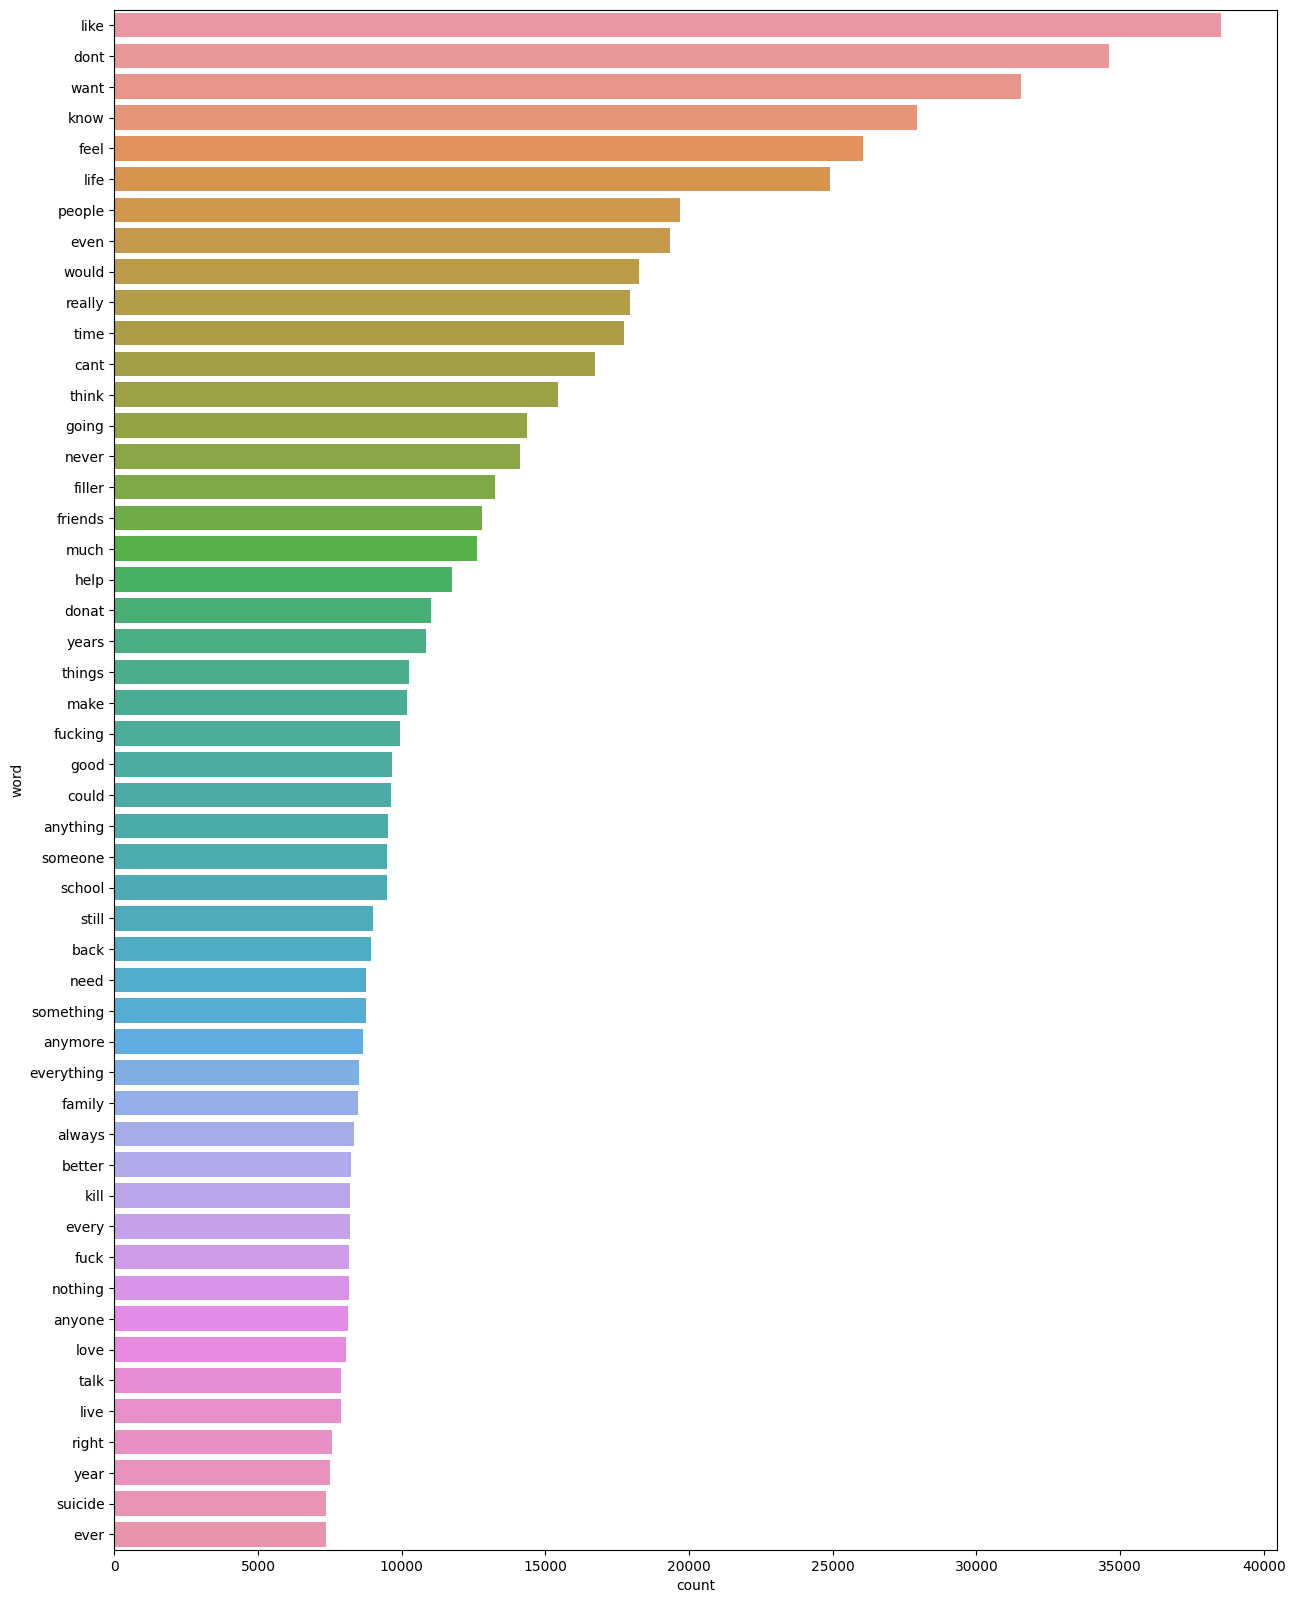

In [95]:
from collections import Counter
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Count word frequencies
word_counts = Counter(word for post in posts_filtered for word in post)

# Convert to DataFrame
word_freq = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Sort by count in descending order
word_freq = word_freq.sort_values(by='count', ascending=False)

# Plot the top 50 words
plt.figure(figsize=(15, 20))
sns.barplot(x='count', y='word', data=word_freq.iloc[:50])
plt.show()

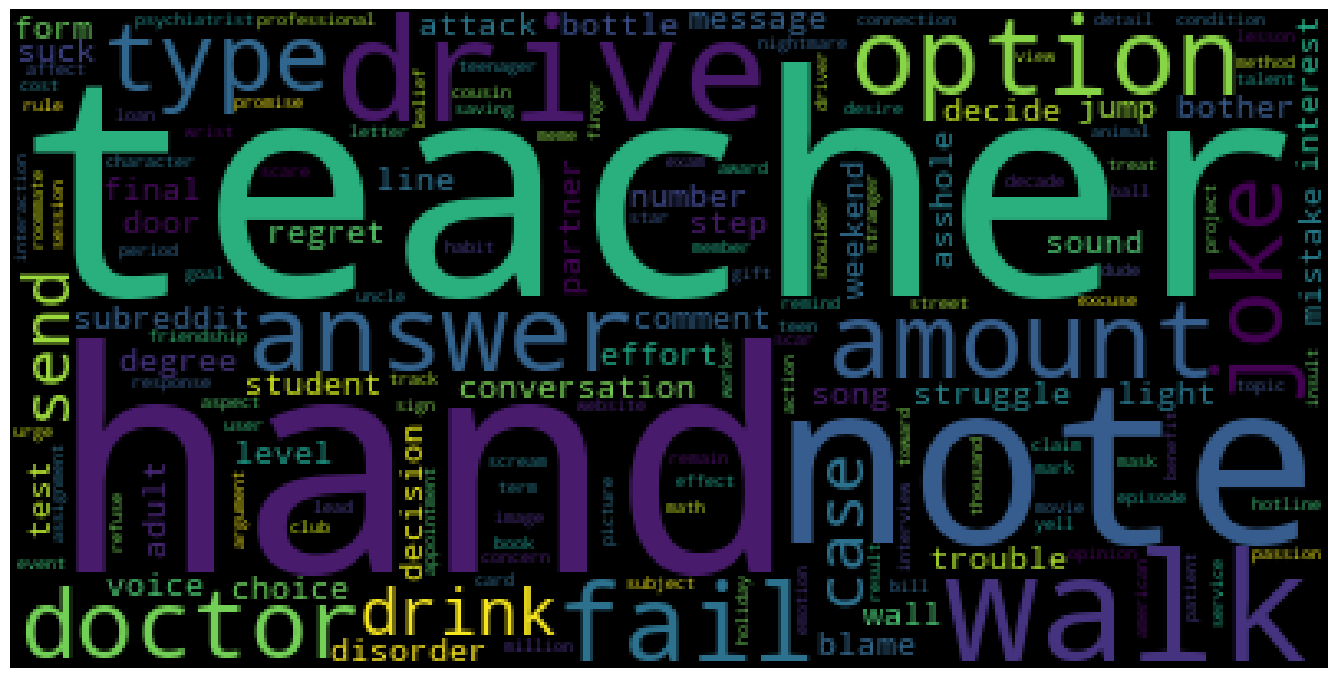

In [96]:
from wordcloud import WordCloud  # Import WordCloud

# Assuming you have defined feature_names
feature_names = word_freq['word'].values

# Create WordCloud object
wc = WordCloud(max_words=300)

# Generate WordCloud
wc.generate(' '.join(word for word in feature_names[500:3500]))

# Plot the WordCloud
plt.figure(figsize=(17, 12))
plt.axis('off')
plt.imshow(wc)
plt.show()


In [97]:
df.head()

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently i left my ...,suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,iam so losthello my name is adam 16 and iave b...,suicide
5,11,honetly idki dont know what im even doing here...,suicide
6,12,trigger warning excuse for self inflicted burn...,suicide


## **Lemmatization**

In [98]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        texts_lem.append(text_lem)

    return texts_lem


In [99]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

posts_lem = lemma(posts_filtered)

posts_lem[0]

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


['wife',
 'threaten',
 'suiciderecently',
 'leave',
 'wife',
 'good',
 'cheat',
 'twice',
 'lie',
 'much',
 'decide',
 'refuse',
 'back',
 'days',
 'begin',
 'threaten',
 'suicide',
 'tirelessly',
 'spend',
 'paat',
 'days',
 'talk',
 'keep',
 'hesitate',
 'want',
 'believe',
 'come',
 'back',
 'know',
 'people',
 'threaten',
 'order',
 'happen',
 'really',
 'suppose',
 'handle',
 'death',
 'hand',
 'still',
 'love',
 'wife',
 'cannot',
 'deal',
 'get',
 'cheat',
 'constantly',
 'feel',
 'insecure',
 'worry',
 'today',
 'hope',
 'much',
 'doesnt',
 'happen']

In [100]:
posts_ready = []
for posts in posts_lem:
    string = ' '
    string = string.join(posts)
    posts_ready.append(string)

In [101]:
len(posts_ready)

50000

In [102]:
# original DataFrame and posts_ready list of preprocessed text
df_preprocess['original_text'] = df['text']
df_preprocess['preprocessed_text'] = posts_ready

# Display the resulting DataFrame
df_preprocess[['original_text', 'preprocessed_text', 'class']].head()

,original_text,preprocessed_text,class
0,ex wife threatening suiciderecently i left my ...,wife threaten suiciderecently leave wife good ...,suicide
3,i need helpjust help me im crying so hard,need helpjust help cry hard,suicide
4,iam so losthello my name is adam 16 and iave b...,losthello name adam iave struggle years afraid...,suicide
5,honetly idki dont know what im even doing here...,honetly idki dont know even feel like nothing ...,suicide
6,trigger warning excuse for self inflicted burn...,trigger warn excuse self inflict burnsi know c...,suicide


In [103]:
data = [{'text': text, 'class': label} for text, label in zip(posts_ready, df['class'])]

# Convert the list of dictionaries to a DataFrame
df_ready = pd.DataFrame(data)

# Separate X and y
X = df_ready['text']
y = df_ready['class']

df_ready

,text,class
0,wife threaten suiciderecently leave wife good ...,suicide
1,need helpjust help cry hard,suicide
2,losthello name adam iave struggle years afraid...,suicide
3,honetly idki dont know even feel like nothing ...,suicide
4,trigger warn excuse self inflict burnsi know c...,suicide
...,...,...
49995,full send want friends,non-suicide
49996,bird eat bird eat spider make bird eater eater,non-suicide
49997,guy scale hows wake last hour scale tire,non-suicide
49998,free need internet annoy little enby help,non-suicide


## **Text to Numeric**

In [104]:
from keras.preprocessing.text import Tokenizer
 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words= 25000,lower=True)
tokenizer.fit_on_texts(X)


In [105]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(X) # this converts texts into some numeric sequences 
X = pad_sequences(X,maxlen=150,padding='post') # this makes the length of all numeric sequences equal 
X[1]

array([   29, 12912,    20,   215,    97,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [106]:
X.shape

(50000, 150)

## **Word2Vec**

In [107]:
# pip install gensim
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension

In [108]:

# from gensim.models import Word2Vec
# model = Word2Vec(sentences,min_count = 2)
# words = model.wv.index_to_key
from gensim.models import KeyedVectors

#glove_model = KeyedVectors.load_word2vec_format('/kaggle/input/glove42b300dtxt/glove.42B.300d.txt', binary=False)

vector_size = 100
num_words = 25000
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape
for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.index_to_key:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

## **MODEL**

In [109]:
import tensorflow
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional,SimpleRNN 

# from tensorflow.compat.v1.keras.layers import CuDNNRNN
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [110]:
#Splitting the data into training and testing
from sklearn.model_selection import train_test_split
y=pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 123)

Training Bi-LSTM-RNN Model...
313/313 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7112
Epoch 1: val_accuracy improved from -inf to 0.51210, saving model to /kaggle/working/models/best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 21s 67ms/step - loss: 0.6820 - accuracy: 0.5121
Training Bi-LSTM Model...
313/313 [==============================] - ETA: 0s - loss: 0.3686 - accuracy: 0.8436
Epoch 1: val_accuracy improved from 0.51210 to 0.87540, saving model to /kaggle/working/models/best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 17s 53ms/step - loss: 0.3112 - accuracy: 0.8754
Training LSTM Model...
313/313 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.7138
Epoch 1: val_accuracy did not improve from 0.87540
313/313 [==============================] - 49s 143ms/step - loss: 0.5441 - accuracy: 0.7138 - val_loss: 0.3465 - val_accuracy: 0.8577


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 7s 23ms/step - loss: 0.3465 - accuracy: 0.8577
Bi-LSTM-RNN Model Evaluation Loss: 0.6820085644721985
Bi-LSTM-RNN Model Evaluation Accuracy: 0.5120999813079834
Bi-LSTM Model Evaluation Loss: 0.3112184703350067
Bi-LSTM Model Evaluation Accuracy: 0.8754000067710876
LSTM Model Evaluation Loss: 0.3464839458465576
LSTM Model Evaluation Accuracy: 0.857699990272522


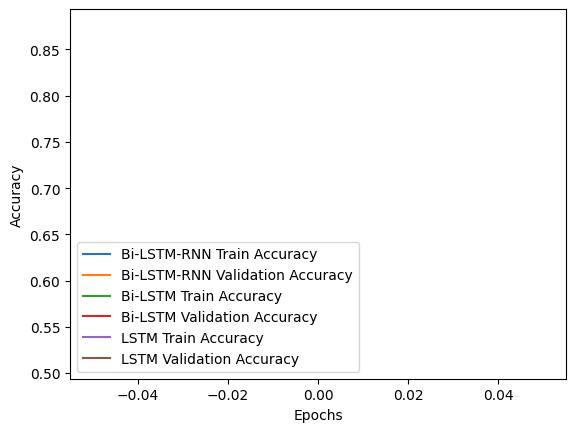

         Model      Loss  Accuracy
0  Bi-LSTM-RNN  0.682009    0.5121
1      Bi-LSTM  0.311218    0.8754
2         LSTM  0.346484    0.8577
313/313 [==============================] - 8s 21ms/step
Bi-LSTM-RNN Precision: 0.5016386726751332
Bi-LSTM-RNN Recall: 0.9973528812869069
Bi-LSTM-RNN F1 Score: 0.6675298126064736
Bi-LSTM Precision: 0.8467360454115421
Bi-LSTM Recall: 0.9112197108531868
Bi-LSTM F1 Score: 0.877795213809337
LSTM Precision: 0.8472720031859817
LSTM Recall: 0.8664223172469966
LSTM F1 Score: 0.8567401590657406


,Model,Precision,Recall,F1 Score
0,Bi-LSTM-RNN,0.501639,0.997353,0.667530
1,Bi-LSTM,0.846736,0.911220,0.877795
2,LSTM,0.847272,0.866422,0.856740


In [111]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define model architectures
EMBEDDING_DIM = 100

def create_bilstm_rnn_model(input_shape, num_classes):
    model = Sequential([
        Embedding(input_dim=num_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=X.shape[1], weights=[gensim_weight_matrix], 
                    trainable=False),
        Dropout(0.275),
        Bidirectional(LSTM(units=350, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(units=450, return_sequences=True)),
        Dropout(0.225),
        Bidirectional(LSTM(units=500, return_sequences=True)),
        Dropout(0.45),
        SimpleRNN(125, return_sequences=True),
        Dropout(0.425),
        SimpleRNN(150, return_sequences=False),
        Dense(2, activation='softmax')
    ])
    return model

def create_bilstm_model(input_shape, num_classes):
    model = Sequential([
        Embedding(input_dim=num_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=X.shape[1], weights=[gensim_weight_matrix], 
                    trainable=False),
        Dropout(0.275),
        Bidirectional(LSTM(units=350, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(units=450, return_sequences=True)),
        Dropout(0.225),
        Bidirectional(LSTM(units=500, return_sequences=False)),
        Dropout(0.45),
        Flatten(),
        Dense(2, activation='softmax')
    ])
    return model

def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Embedding(input_dim=num_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=X.shape[1], weights=[gensim_weight_matrix], 
                    trainable=False),
        Dropout(0.275),
        LSTM(units=350, return_sequences=True),
        Dropout(0.25),
        LSTM(units=450, return_sequences=True),
        Dropout(0.225),
        LSTM(units=500, return_sequences=False),
        Dropout(0.45),
        Flatten(),
        Dense(2, activation='softmax')
    ])
    return model

# Compile models
num_classes = 2
bilstm_rnn_model = create_bilstm_rnn_model(X.shape[1], num_classes)
bilstm_model = create_bilstm_model(X.shape[1], num_classes)
lstm_model = create_lstm_model(X.shape[1], num_classes)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
mc = ModelCheckpoint('/kaggle/working/models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Train and evaluate models
models = {'Bi-LSTM-RNN': bilstm_rnn_model, 'Bi-LSTM': bilstm_model, 'LSTM': lstm_model}
evaluations = {}
histories = {}

for name, model in models.items():
    print(f"Training {name} Model...")
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    history = model.fit(X_train, y_train, 
                        epochs=1, batch_size=128, 
                        validation_data=(X_test, y_test),
                        verbose=1, callbacks=[mc])
    
    # Save model
    model.save(f'save_model_{name}.h5')
    
    # Save history
    histories[name] = history.history
    
    # Evaluate model
    evaluation = model.evaluate(X_test, y_test)
    evaluations[name] = evaluation

# Print evaluation results
for name, evaluation in evaluations.items():
    print(f"{name} Model Evaluation Loss:", evaluation[0])
    print(f"{name} Model Evaluation Accuracy:", evaluation[1])

# Plot training curves
for name, history in histories.items():
    plt.plot(history['accuracy'], label=f'{name} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'{name} Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model Comparison Table
results = {
    'Model': list(evaluations.keys()),
    'Loss': [evaluation[0] for evaluation in evaluations.values()],
    'Accuracy': [evaluation[1] for evaluation in evaluations.values()]
}

results_df = pd.DataFrame(results)
print(results_df)

# Calculate precision, recall, and F1-score for each model
precision = {}
recall = {}
f1 = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    precision[name] = precision_score(np.argmax(y_test.to_numpy(), axis=1), y_pred)
    recall[name] = recall_score(np.argmax(y_test.to_numpy(), axis=1), y_pred)
    f1[name] = f1_score(np.argmax(y_test.to_numpy(), axis=1), y_pred)

# Print precision, recall, and F1-score for each model
for name in models.keys():
    print(f"{name} Precision:", precision[name])
    print(f"{name} Recall:", recall[name])
    print(f"{name} F1 Score:", f1[name])

# Create DataFrame for precision, recall, and F1-score
results_metrics = {
    'Model': list(models.keys()),
    'Precision': [precision[name] for name in models.keys()],
    'Recall': [recall[name] for name in models.keys()],
    'F1 Score': [f1[name] for name in models.keys()]
}

results_metrics_df = pd.DataFrame(results_metrics)

# Style the DataFrame for better visualization
styled_results_metrics_df = results_metrics_df.style.background_gradient(cmap='viridis', subset=['Precision', 'Recall', 'F1 Score'])
styled_results_metrics_df = styled_results_metrics_df.set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '16px')]
}, {
    'selector': 'td',
    'props': [('font-size', '16px')]
}])
styled_results_metrics_df = styled_results_metrics_df.set_properties(**{'width': '300px', 'text-align': 'center'})
styled_results_metrics_df


# **ATTENTION MODEL**

In [130]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Embedding, LSTM, Bidirectional, SimpleRNN, Dense, Dropout
from tensorflow.keras import Sequential

class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        features, hidden = inputs
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

def create_bilstm_rnn_attention_model(input_shape, num_classes):
    model = Sequential([
        Embedding(input_dim=num_words, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=X.shape[1], weights=[gensim_weight_matrix], 
                    trainable=False),
        Dropout(0.275),
        Bidirectional(LSTM(units=350, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(units=450, return_sequences=True)),
        Dropout(0.225),
        Bidirectional(LSTM(units=500, return_sequences=True)),
        Dropout(0.45),
        SimpleRNN(125, return_sequences=True),
        Dropout(0.425),
        SimpleRNN(150, return_sequences=True),
        BahdanauAttention(64),  # Ensure that the inputs to this layer are in the correct format
        Dense(2, activation='softmax')
    ])
    return model


# Assuming you have the necessary data (X_train, y_train, X_test, y_test) and variables (num_words, EMBEDDING_DIM, gensim_weight_matrix) defined

num_classes = 2
input_shape = X_train.shape[1:]
num_words = num_words  # Define this based on your tokenizer
embedding_dim = 100  # Define this based on your embedding dimension
weights_matrix = gensim_weight_matrix  # Assuming you have the weights matrix


# Create the model
attention_model = create_bilstm_rnn_attention_model(X.shape[1], num_classes)

# Compile the model
attention_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = attention_model.fit(X_train, y_train, epochs=1, batch_size=128, validation_data=(X_test, y_test))

# After training, you can obtain the attention weights for a given input by using model.predict() and accessing the attention weights layer output
# For example:
attention_weights = attention_model.predict(X_test)[1]  # Assuming attention layer is the second layer after Embedding
# You can now analyze these attention weights to identify influential words


OperatorNotAllowedInGraphError: Exception encountered when calling layer "bahdanau_attention_16" (type BahdanauAttention).

in user code:

    File "/tmp/ipykernel_34/3736818547.py", line 13, in call  *
        features, hidden = inputs

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.


Call arguments received by layer "bahdanau_attention_16" (type BahdanauAttention):
  • inputs=tf.Tensor(shape=(None, 150, 150), dtype=float32)

In [ ]:
import numpy as np

# Get predictions and attention weights for test data
predictions = attention_model.predict(X_test)

attention_weights = predictions[1]  # Assuming attention layer is the second layer after Embedding

# Convert attention weights to numpy array
attention_weights_np = np.array(attention_weights)

print("Shape of attention weights array:", attention_weights_np)

# Define a function to visualize influential words
def visualize_influential_words(input_sequence, attention_weights):
    # Get the index of the most influential word
    influential_word_index = np.argmax(attention_weights)
    # Get the corresponding word from the input sequence
    influential_word = input_sequence[influential_word_index]
    return influential_word

# Choose a random sample index from the test data
sample_index = np.random.randint(0, len(X_test))

# Get the input sequence and its corresponding attention weights
input_sequence = X_test[sample_index]
attention_weights_sample = attention_weights_np[sample_index]


# Visualize influential words for the selected sample
influential_word = visualize_influential_words(input_sequence, attention_weights_sample)
print("Influential Word:", influential_word)


# **LOAD MODEL**

In [ ]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the saved models
best_bilstm_rnn_model = load_model('save_model_Bi-LSTM-RNN.h5')
best_bilstm_model = load_model('save_model_Bi-LSTM.h5')
best_lstm_model = load_model('save_model_LSTM.h5')

# Example input post
input_post = "i want to die and want to play basketball"

# Function to highlight influential words
def highlight_words(text, influential_words):
    highlighted_text = text
    for word in influential_words:
        highlighted_text = highlighted_text.replace(word, f'<span style="background-color: yellow;">{word}</span>')
    return highlighted_text

# Tokenize the input post
tokenized_input_post = tokenizer.texts_to_sequences([input_post]) 

# Define maxlen (maximum length of sequences after padding)
maxlen = 150

# Pad the sequences to ensure uniform length
padded_input_post = pad_sequences(tokenized_input_post, maxlen=maxlen, padding='post')

# Predict the class of the input post using each model
predictions_bilstm_rnn = best_bilstm_rnn_model.predict(padded_input_post)
predictions_bilstm = best_bilstm_model.predict(padded_input_post)
predictions_lstm = best_lstm_model.predict(padded_input_post)

# Function to analyze predictions and highlight influential words
def analyze_and_highlight(predictions, input_post):
    # For this simple example, let's assume the influential words are those with the highest probability
    influential_words = [input_post.split()[i] for i in np.argsort(predictions[0])[-3:]]
    highlighted_post = highlight_words(input_post, influential_words)
    return highlighted_post

# Analyze predictions and highlight influential words for each model
highlighted_post_bilstm_rnn = analyze_and_highlight(predictions_bilstm_rnn, input_post)
highlighted_post_bilstm = analyze_and_highlight(predictions_bilstm, input_post)
highlighted_post_lstm = analyze_and_highlight(predictions_lstm, input_post)

from IPython.display import HTML

# Function to display HTML content
def display_html(html_content):
    display(HTML(html_content))

# Display the highlighted posts
print("Highlighted Post - Bi-LSTM-RNN:")
display_html(highlighted_post_bilstm_rnn)

print("Highlighted Post - Bi-LSTM:")
display_html(highlighted_post_bilstm)

print("Highlighted Post - LSTM:")
display_html(highlighted_post_lstm)


In [ ]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.preprocessing import LabelEncoder

class PostHighlighter:
    def __init__(self):
        self.best_bilstm_rnn_model = None
        self.best_bilstm_model = None
        self.best_lstm_model = None
        self.class_mapping = {0: 'non-suicide', 1: 'suicide'}  # Mapping of numerical labels to class names

    def load_models(self, bilstm_rnn_model_path, bilstm_model_path, lstm_model_path):
        self.best_bilstm_rnn_model = load_model(bilstm_rnn_model_path)
        self.best_bilstm_model = load_model(bilstm_model_path)
        self.best_lstm_model = load_model(lstm_model_path)

    def highlight_words(self, text, influential_words):
        highlighted_text = text
        for word in influential_words:
            highlighted_text = highlighted_text.replace(word, f'<span style="background-color: yellow;">{word}</span>')
        return highlighted_text

    def classify_post(self, input_post):
        if not all([self.best_bilstm_rnn_model, self.best_bilstm_model, self.best_lstm_model]):
            print("Models not loaded. Please load the models first.")
            return
        
        # Tokenize the input post
        tokenized_input_post = tokenizer.texts_to_sequences([input_post])

        # Pad the sequences to ensure uniform length
        maxlen = 150
        padded_input_post = pad_sequences(tokenized_input_post, maxlen=maxlen, padding='post')

        # Predict the class of the input post using each model
        predictions_bilstm_rnn = self.best_bilstm_rnn_model.predict(padded_input_post)
        predictions_bilstm = self.best_bilstm_model.predict(padded_input_post)
        predictions_lstm = self.best_lstm_model.predict(padded_input_post)

        # Classify the post based on the model with the highest confidence
        model_names = ['Bi-LSTM-RNN', 'Bi-LSTM', 'LSTM']
        predicted_labels = []
        highlighted_posts = []
        for name, prediction in zip(model_names, [predictions_bilstm_rnn, predictions_bilstm, predictions_lstm]):
            predicted_label = np.argmax(prediction)
            predicted_class = self.class_mapping[predicted_label]  # Map numerical label to class name
            influential_words = [input_post.split()[i] for i in np.argsort(prediction[0])[-3:]]
            highlighted_post = self.highlight_words(input_post, influential_words)
            predicted_labels.append((name, predicted_class))  # Use predicted class instead of numerical label
            highlighted_posts.append((name, highlighted_post))

        return predicted_labels, highlighted_posts

# Example usage:
post_highlighter = PostHighlighter()

# Load the trained models
post_highlighter.load_models('save_model_Bi-LSTM-RNN.h5', 'save_model_Bi-LSTM.h5', 'save_model_LSTM.h5')

# Define an input post
input_post = "let not play football"

from IPython.display import HTML

# Classify the input post and highlight influential words
predicted_labels, highlighted_posts = post_highlighter.classify_post(input_post)

# Display the highlighted posts
print("Predicted Labels:", predicted_labels)
for name, highlighted_post in highlighted_posts:
    print(f"{name}:")
    display_html(highlighted_post)

